In [4]:
from __future__ import division, print_function
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')
from sigr.evaluation import CrossValEvaluation, Exp
from sigr import Context
from sigr.utils import Bunch
from sigr.data import Dataset, Preprocess
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', rc={'font.family': 'Arial', 'font.size': 7})
sns.set_style('whitegrid')
import pandas as pd


class Report(Bunch):
    
    def __call__(self):
        crossval = getattr(self, 'crossval', 'one-fold-intra-subject')
        evaluation = CrossValEvaluation(crossval_type=crossval, batch_size=1000)
        exp = Exp(dataset=Dataset.from_name(self.dataset),
                  dataset_args=getattr(self, 'dataset_args', None),
                  Mod=dict(num_gesture=self.num_gesture,
                           context=[mx.gpu(0)],
                           symbol_kargs=dict(dropout=0,
                                             num_semg_row=self.num_semg_row, num_semg_col=self.num_semg_col, 
                                             num_filter=64),
                           params='.cache/sigr-{}-{}-%d-v{}/model-{:04d}.params'.format(
                               self.dataset.replace('/', '-'),
                               crossval,
                               self.version,
                               getattr(self, 'num_epoch', 28)),
                           **getattr(self, 'mod', {})))
        with Context(parallel=True):
            acc = evaluation.accuracies(
                [Exp(vote=-1, **exp)],
                folds=list(range(self.num_fold)))
            trialacc = acc.mean()
        with Context(parallel=True):
            acc = evaluation.vote_accuracy_curves(
                [exp],
                folds=list(range(self.num_fold)),
                windows=self.windows,
                balance=getattr(self, 'balance', False))
        std = acc.std(axis=(0, 1))
        acc = acc.mean(axis=(0, 1))

        threshold = self.threshold
        if not isinstance(threshold, (tuple, list, np.ndarray)):
            threshold = [threshold]
        df = pd.DataFrame([100 * acc[0],
                           100 * std[0],
                           100 * acc[self.windows == self.w150][0],
                           100 * trialacc
                          ] + [self.frame_to_ms(self.windows[np.where(acc > t)[0][0]] if acc[-1] > t else 0)
                               for t in threshold],
                          index=['No voting', 
                                 'Std',
                                 '150ms voting', 
                                 'Trial voting'
                                ] + ['%f%% window' % (100 * t) for t in threshold])
        print(df.round(1).to_string(header=False))
        
        plt.gca().plot(self.windows, 100 * acc, label=getattr(self, 'label', None))
        plt.xlabel('Voting window (ms)')
        plt.ylabel('Accuracy (%)', labelpad=0)
        plt.xlim(self.windows[0], self.windows[-1])
        plt.ylim(self.ymin, 100)
        if hasattr(self, 'xticks'):
            if hasattr(self, 'xlabels'):
                plt.xticks(self.xticks, self.xlabels)
            else:
                plt.xticks(self.xticks, [str(self.frame_to_ms(x)) for x in self.xticks])
        #plt.gcf().set_size_inches(6, 4)
        #plt.show()
        
    def frame_to_ms(self, frame):
        if frame < 1:
            return frame
        ms = np.round(frame / Dataset.from_name(self.dataset).framerate * 1000)
        return int(np.round(ms)) if np.abs(np.round(ms) - ms) < 1e-4 else ms
        
        
class NinaPro(Report):
    
    def __init__(self, **kargs):
        options = dict(
            threshold=0.9
        )
        options.update(kargs)
        super(NinaPro, self).__init__(**options)
        self.num_fold = 27
        self.num_semg_row = 1
        self.num_semg_col = 10
        self.windows = np.arange(1, 101)
        self.w150 = 15
        self.xticks = [1, 20, 40, 60, 80, 100]
        #self.xlabels = ['1', '200', '400', '600', '800', '1000']
        self.ymin = 75
        self.balance = True
        
        
class CapgMyo(Report):
    
    def __init__(self, **kargs):
        super(CapgMyo, self).__init__(**kargs)
        self.num_semg_row = 16
        self.num_semg_col = 8
        self.windows = np.arange(1, 1001)
        self.threshold = [0.9, 0.95, 0.99]
        self.w150 = 150
        self.xticks = [1, 200, 400, 600, 800, 1000]
        self.ymin = 75
        
        
class CSL(Report):
    
    def __init__(self, **kargs):
        super(CSL, self).__init__(**kargs)
        self.num_semg_row = 24
        self.num_semg_col = 7
        self.windows = np.arange(1, 2049)
        self.threshold = 0.904
        self.w150 = int(np.round(0.15 * 2048))
        self.xticks = [1] + [256 * x for x in range(1, 9)]
        self.ymin = 50
        self.num_gesture = 27
        self.dataset_args = dict(preprocess=Preprocess.parse('(csl-bandpass,csl-cut,median)'))
        self.num_fold = 250
        self.mod = dict(adabn=True, num_adabn_epoch=10)
        self.crossval = 'intra-session'
        self.num_epoch = 14
        self.balance = True
        
        
def report(cls, *args, **kargs):
    #plt.figure(figsize=(6, 6./4*3))
    if not args:
        cls(**kargs)()
    else:
        assert not kargs
        for i, arg in enumerate(args):
            if i:
                print('---')
            cls(**arg)()
        plt.legend(loc='lower right')
        
        
def savefig(prefix):
    for ext in ['.jpg', '.eps', '.pdf']:
        plt.savefig(prefix + ext, dpi=300, bbox_inches='tight', pad_inches=0.05)

No voting          89.3
Std                 4.9
150ms voting       99.5
Trial voting       99.7
90.000000% window   3.0
95.000000% window   7.0
99.000000% window  40.0
---
No voting           85.6
Std                  6.0
150ms voting        98.6
Trial voting        99.5
90.000000% window    5.0
95.000000% window   16.0
99.000000% window  307.0
---
No voting          84.6
Std                 5.8
150ms voting       99.2
Trial voting       99.5
90.000000% window   5.0
95.000000% window  12.0
99.000000% window  87.0
---
No voting           78.9
Std                  5.3
150ms voting        83.0
Trial voting        97.7
90.000000% window  610.0
---
No voting           80.1
Std                  5.0
150ms voting        84.4
Trial voting        98.3
90.000000% window  530.0


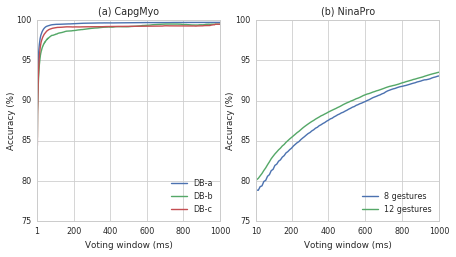

In [5]:
plt.subplot(121)
report(CapgMyo, 
       dict(dataset='dba', version='958.3.2', num_gesture=8, num_fold=18, label='DB-a'),
       dict(dataset='dbb', version='958.6.1', num_gesture=8, num_fold=10, label='DB-b'),
       dict(dataset='dbc', version='958.7.1', num_gesture=12, num_fold=10, label='DB-c'))
plt.title('(a) CapgMyo')
print('---')
plt.subplot(122)
report(NinaPro,
       dict(dataset='ninapro-db1/g8', version='958.22.1', num_gesture=8, label='8 gestures'),
       dict(dataset='ninapro-db1/g12', version='958.21.1', num_gesture=12, label='12 gestures'))
plt.title('(b) NinaPro')
plt.gcf().set_size_inches(7.20472, 7.20472 / 2)
savefig('../.cache/figures/sdata-curve')

No voting          89.3
Std                 4.9
150ms voting       99.5
Trial voting       99.7
99.000000% window  40.0
---
No voting           85.6
Std                  6.0
150ms voting        98.6
Trial voting        99.5
99.000000% window  307.0
---
No voting          84.6
Std                 5.8
150ms voting       99.2
Trial voting       99.5
99.000000% window  87.0
---
No voting          78.9
Std                 5.3
150ms voting       83.0
Trial voting       97.7
99.000000% window   0.0
---
No voting          80.1
Std                 5.0
150ms voting       84.4
Trial voting       98.3
99.000000% window   0.0


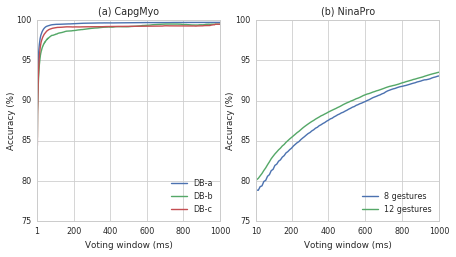

In [79]:
plt.subplot(121)
report(CapgMyo, 
       dict(dataset='dba', version='958.3.2', num_gesture=8, num_fold=18, label='DB-a'),
       dict(dataset='dbb', version='958.6.1', num_gesture=8, num_fold=10, label='DB-b'),
       dict(dataset='dbc', version='958.7.1', num_gesture=12, num_fold=10, label='DB-c'))
plt.title('(a) CapgMyo')
print('---')
plt.subplot(122)
report(NinaPro,
       dict(dataset='ninapro-db1/g8', version='958.22.1', num_gesture=8, label='8 gestures'),
       dict(dataset='ninapro-db1/g12', version='958.21.1', num_gesture=12, label='12 gestures'))
plt.title('(b) NinaPro')
plt.gcf().set_size_inches(7.20472, 7.20472 / 2)
savefig('../.cache/figures/sdata-curve')

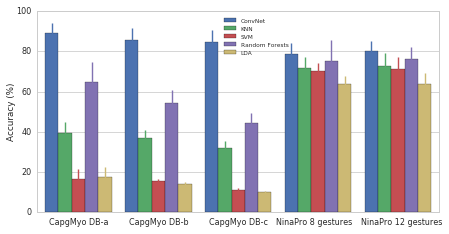

In [78]:
def plot_bars(mean, std, db, clf, 
              color=sns.color_palette(),
              ymax=100,
              figsize=(7.20472, 7.20472 / 4 * 3),
              legend=True,
              xtick_offset=0,
              loc='best'):
    '''
    Like "Self-Control in Decision-Making Involves Modulation of the vmPFC Valuation System
    '''
    mean = np.asarray(mean)
    std = np.asarray(std)
    
    margin = len(clf) + 1
    width = 1

    # Grid
    plt.gca().xaxis.grid()
    
    for i in range(len(clf)):
        plt.bar(
            i + margin * np.arange(len(db)), mean[:, i], yerr=std[:, i], width=width,
            color=color[i], label=clf[i]
        )

    plt.xticks(len(clf) / 2 + margin * (np.arange(len(db)) + xtick_offset), db)
    plt.xlim(-0.6, len(db) * (len(clf) + 1) - 0.4)
    plt.ylim(0, ymax)
    plt.tick_params(top='off', right='off', bottom='off')
    plt.ylabel('Accuracy (%)', labelpad=0)
    if legend:
        plt.legend(fontsize='small', loc=loc)
    # 16:9
    if figsize:
        plt.gcf().set_size_inches(*figsize)
        

evaluation = CrossValEvaluation(crossval_type='one-fold-intra-subject')
ninapro_g12_acc = 100 * evaluation.accuracies(
    [Exp(root='../.cache/sigr-ninapro-db1-g12-one-fold-intra-subject-%d-v{}'.format(version))
     for version in ['958.25.1', '958.25.2', '958.25.3', '958.25.4']],
    folds=range(27))
dba_acc = 100 * evaluation.accuracies(
    [Exp(root='../.cache/sigr-dba-one-fold-intra-subject-%d-v{}'.format(version))
     for version in ['958.26.1', '958.26.2', '958.26.3', '958.26.4']],
    folds=range(10))
dbb_acc = 100 * evaluation.accuracies(
    [Exp(root='../.cache/sigr-dbb-one-fold-intra-subject-%d-v{}'.format(version))
     for version in ['958.27.1', '958.27.2', '958.27.3', '958.27.4']],
    folds=range(10))
dbc_acc = 100 * evaluation.accuracies(
    [Exp(root='../.cache/sigr-dbc-one-fold-intra-subject-%d-v{}'.format(version))
     for version in ['958.28.1', '958.28.2', '958.28.3', '958.28.4']],
    folds=range(10))

#plt.rc('font', family='Arial', size='7')
plot_bars(
    [[89.3] + list(dba_acc.mean(axis=1)),
     [85.6] + list(dbb_acc.mean(axis=1)),
     [84.6] + list(dbc_acc.mean(axis=1)),
     [78.90, 71.59, 70.12, 75.11, 63.75],
     [80.1] + list(ninapro_g12_acc.mean(axis=1))],
    [[4.9] + list(dba_acc.std(axis=1)),
     [6.0] + list(dbb_acc.std(axis=1)),
     [5.8] + list(dbc_acc.std(axis=1)),
     [5.3, 5.44, 4.20, 10.32, 4.00],
     [5.0] + list(ninapro_g12_acc.std(axis=1))],
    ['CapgMyo DB-a', 'CapgMyo DB-b', 'CapgMyo DB-c', 'NinaPro 8 gestures', 'NinaPro 12 gestures'],
    ['ConvNet', 'KNN', 'SVM', 'Random Forests', 'LDA'],
    figsize=(7.20472, 7.20472 / 2),
    xtick_offset=[0, 0, 0, -0.05, 0.05],
    loc=(0.46, 0.77)
)
savefig('../.cache/figures/sdata-bar')